In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.4.1
True


In [ ]:
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))

CUDA Device Name: NVIDIA RTX A2000


In [ ]:
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_dir = r'C:\Users\aaa\Documents\DATASETS\Organized_Amharic_Character_Dataset'
dataset = ImageFolder(root=data_dir, transform=transform)
targets = np.array(dataset.targets)

train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=targets, random_state=42)
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

print("Data loaders are ready")

for images, labels in train_loader:
    print(images.shape)
    break

Data loaders are ready
torch.Size([64, 1, 224, 224])


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from typing import Dict, List

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: str = 'cuda'):

    results = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": []
    }

    total_training_time = 0

    for epoch in range(epochs):
        start_time = time.time()

        train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        val_loss, val_acc, val_precision, val_recall, val_f1 = validate_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        epoch_time = time.time() - start_time
        total_training_time += epoch_time

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"train_precision: {train_precision:.4f} | "
            f"train_recall: {train_recall:.4f} | "
            f"train_f1: {train_f1:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f} | "
            f"val_precision: {val_precision:.4f} | "
            f"val_recall: {val_recall:.4f} | "
            f"val_f1: {val_f1:.4f} | "
            f"epoch_time: {epoch_time:.2f} seconds"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["val_precision"].append(val_precision)
        results["val_recall"].append(val_recall)
        results["val_f1"].append(val_f1)

    print(f"Total training time: {total_training_time:.2f} seconds")

    return results

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str = 'cuda'):
    model.train()

    train_loss, train_acc = 0, 0
    all_preds = []
    all_labels = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        all_preds.extend(y_pred_class.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        if (batch + 1) % 10 == 0:
            avg_loss = train_loss / (batch + 1)
            avg_acc = train_acc / (batch + 1)
            print(f"Processed {batch + 1}/{len(dataloader)} batches. Current loss: {avg_loss:.4f}")

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return train_loss, train_acc, train_precision, train_recall, train_f1

def validate_step(model: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  device: str = 'cuda'):
    model.eval()

    val_loss, val_acc = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)

            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = val_pred_logits.argmax(dim=1)
            all_preds.extend(val_pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)

    val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return val_loss, val_acc, val_precision, val_recall, val_f1

def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    val_loss = results['val_loss']

    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

In [ ]:
#vgg19
import torch
import torch.nn as nn
import torchvision.models as models

vgg19 = models.vgg19(weights='DEFAULT')

vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

vgg19.classifier = nn.Sequential(*list(vgg19.classifier.children())[:-1])

class CustomVGG19(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG19, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 238

device = torch.device("cuda")
model_2 = CustomVGG19(vgg19, num_classes).to(device)
print("Model 2 setup complete")

for param in model_2.parameters():
    param.requires_grad = True

print("Parameter status after unfreezing all layers and applying dropout:")
for name, param in model_2.named_parameters():
    print(f"{name}: Requires grad: {param.requires_grad}")

Model 2 setup complete
Parameter status after unfreezing all layers and applying dropout:
base_model.features.0.weight: Requires grad: True
base_model.features.2.weight: Requires grad: True
base_model.features.2.bias: Requires grad: True
base_model.features.5.weight: Requires grad: True
base_model.features.5.bias: Requires grad: True
base_model.features.7.weight: Requires grad: True
base_model.features.7.bias: Requires grad: True
base_model.features.10.weight: Requires grad: True
base_model.features.10.bias: Requires grad: True
base_model.features.12.weight: Requires grad: True
base_model.features.12.bias: Requires grad: True
base_model.features.14.weight: Requires grad: True
base_model.features.14.bias: Requires grad: True
base_model.features.16.weight: Requires grad: True
base_model.features.16.bias: Requires grad: True
base_model.features.19.weight: Requires grad: True
base_model.features.19.bias: Requires grad: True
base_model.features.21.weight: Requires grad: True
base_model.feat

In [ ]:
try:
    import torchinfo
except ImportError:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

input_size = [1, 1, 224, 224]

summary(model_2, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
CustomVGG19                              [1, 238]                  --
├─VGG: 1-1                               [1, 4096]                 --
│    └─Sequential: 2-1                   [1, 512, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         576
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                  [1, 64, 224, 224]         36,928
│    │    └─ReLU: 3-4                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-6                  [1, 128, 112, 112]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-8                  [1, 128, 112, 112]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 56, 56]          --
│

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.0001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.3)

Processed 10/472 batches. Current loss: 5.4919
Processed 20/472 batches. Current loss: 5.4878
Processed 30/472 batches. Current loss: 5.4864
Processed 40/472 batches. Current loss: 5.4821
Processed 50/472 batches. Current loss: 5.4785
Processed 60/472 batches. Current loss: 5.4758
Processed 70/472 batches. Current loss: 5.4729
Processed 80/472 batches. Current loss: 5.4683
Processed 90/472 batches. Current loss: 5.4571
Processed 100/472 batches. Current loss: 5.4412
Processed 110/472 batches. Current loss: 5.4212
Processed 120/472 batches. Current loss: 5.3939
Processed 130/472 batches. Current loss: 5.3675
Processed 140/472 batches. Current loss: 5.3410
Processed 150/472 batches. Current loss: 5.3092
Processed 160/472 batches. Current loss: 5.2671
Processed 170/472 batches. Current loss: 5.2191
Processed 180/472 batches. Current loss: 5.1747
Processed 190/472 batches. Current loss: 5.1284
Processed 200/472 batches. Current loss: 5.0832
Processed 210/472 batches. Current loss: 5.0297
P

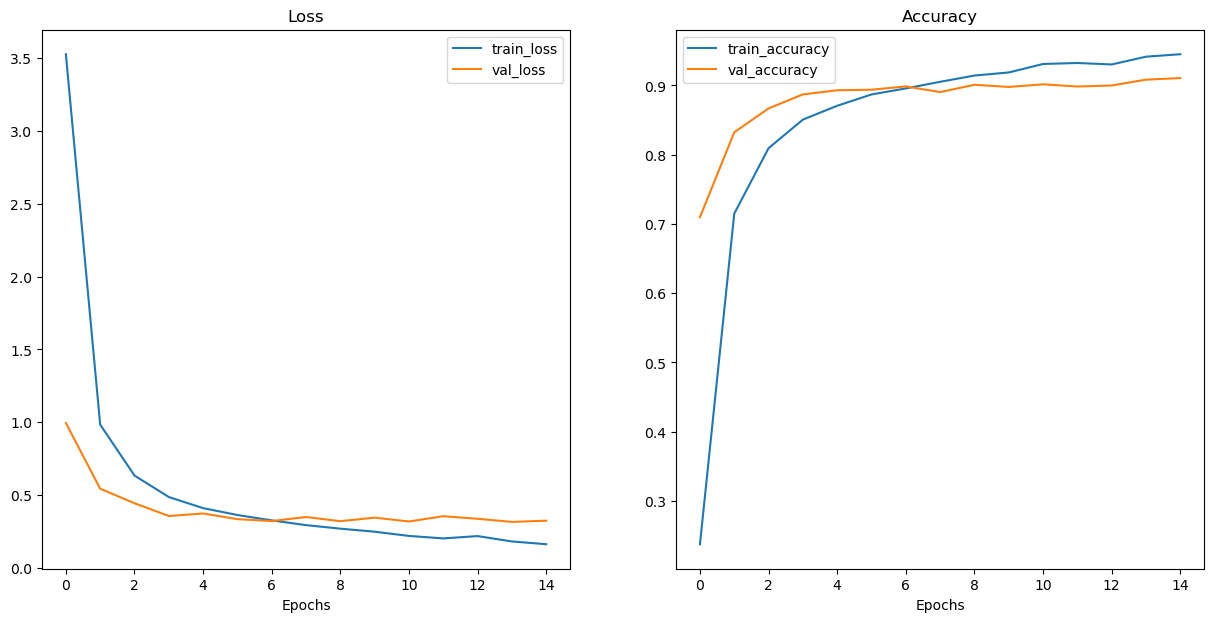

In [ ]:
epochs = 15
results = train(model_2, train_loader, val_loader, optimizer, criterion, epochs)
plot_loss_curves(results)
torch.save(model_2.state_dict(), 'model_2_weights.pth')

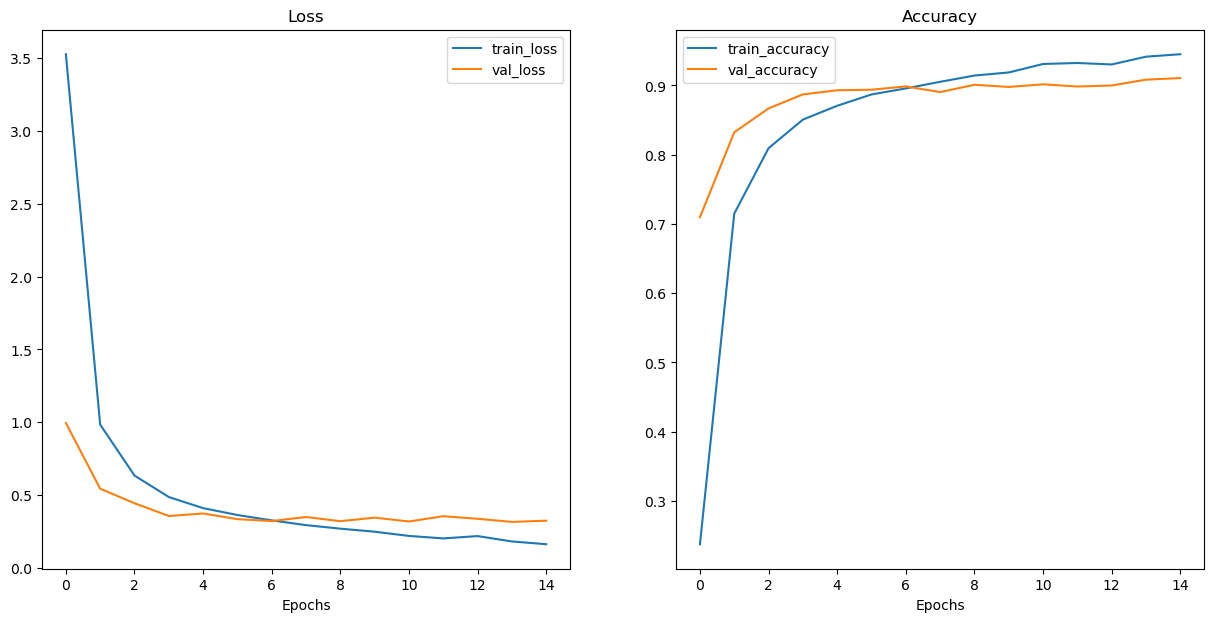

In [ ]:
plot_loss_curves(results)